In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from matplotlib import cm
from matplotlib.patches import Rectangle
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.style as style
style.use('seaborn-colorblind')

<ipython-input-61-c008e4a5a443>:13: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  style.use('seaborn-colorblind')


In [ ]:
with open('drive/MyDrive/bce/RNN_data_21-18-17_23-07-2023.pkl', 'rb') as f:
# with open('drive/MyDrive/mse/RNN_data_21-13-19_23-07-2023.pkl', 'rb') as f:
# with open('drive/MyDrive/bce_untrained/RNN_data_09-39-30_24-07-2023.pkl', 'rb') as f:
# with open('drive/MyDrive/mse_untrained/RNN_data_09-49-22_24-07-2023.pkl', 'rb') as f:
    RNN_data = pickle.load(f)

In [ ]:
RNN_data.keys()

dict_keys(['x_t', 'y_t', 'mask_t', 'task_parameters', 'losses', 'network_params', 'train_params', 'output_units_activity', 'hidden_units_activity', 'final_accuracy'])

In [ ]:
RNN_data['task_parameters'][0]

{'stim1_onset_time': 200,
 'stim1_duration': 200,
 'delay_between_stimuli': 500,
 'delay_before_decision_time': 500,
 'stim2_duration': 200,
 'decision_time_duration': 800,
 'stim_noise': 0.1,
 'dt': 10,
 'tau': 100,
 'T': 2400,
 'N_batch': 50,
 'N_rec': 50,
 'name': 'basicModel',
 'angle1': 6.05498007326237,
 'angle2': 4.8064902511154175,
 'category1': 1,
 'category2': 1,
 'stim1_end_time': 400,
 'stim2_onset_time': 900,
 'stim2_end_time': 1100,
 'decision_time_onset': 1600,
 'decision_time_end': 2400}

In [ ]:
RNN_data['final_accuracy']

0.96

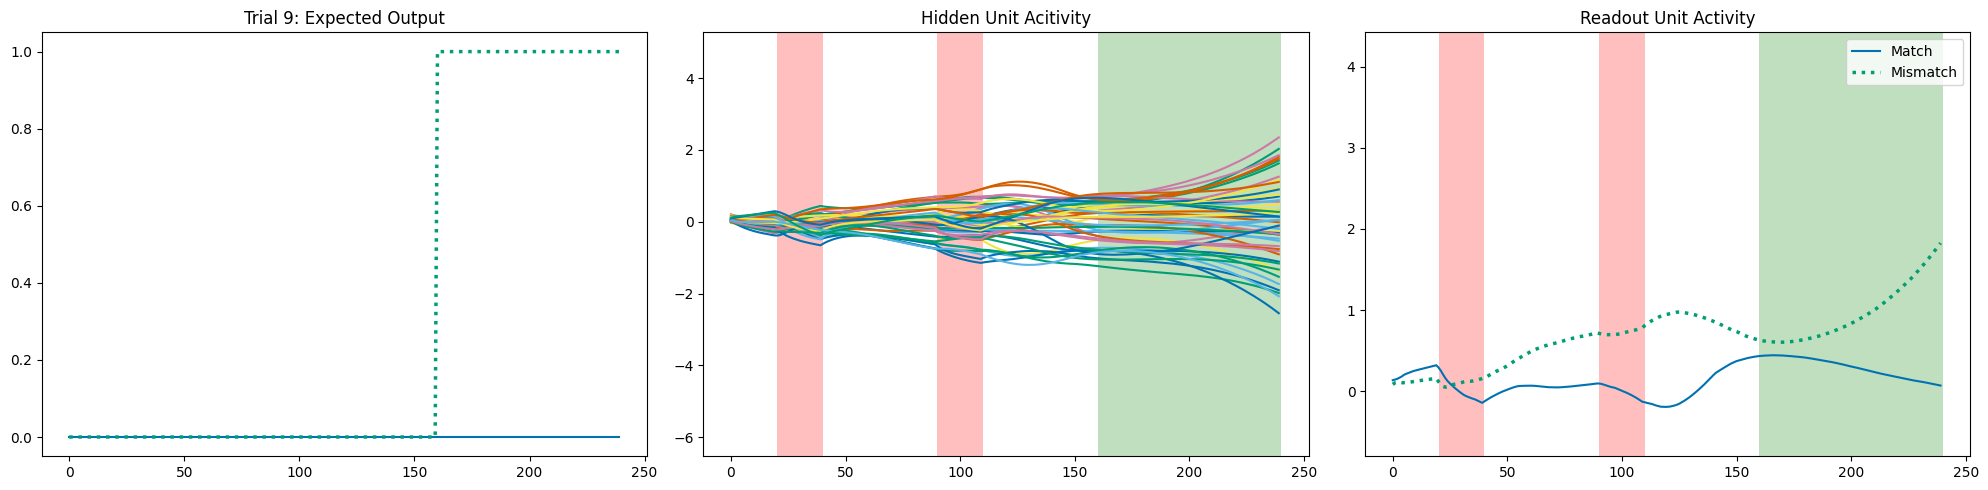

In [ ]:
tp = RNN_data['task_parameters'][0]
dt = tp['dt']
hidden_units_activity_lims = [RNN_data['hidden_units_activity'].min()-0.25, RNN_data['hidden_units_activity'].max()+0.25]
output_units_activity_lims = [RNN_data['output_units_activity'].min()-0.25, RNN_data['output_units_activity'].max()+0.25]


# for i in range(RNN_data['hidden_units_activity'].shape[0]):
for i in [9]:

    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,5))

    ax[0].set_title(f'Trial {i}: Expected Output')
    ax[1].set_title('Hidden Unit Acitivity')
    ax[2].set_title('Readout Unit Activity')

    # ax[0].plot(RNN_data['y_t'][i,:,:])
    ax[0].plot(RNN_data['y_t'][i,:,0])
    ax[0].plot(RNN_data['y_t'][i,:,1], linestyle='dotted', linewidth=2.5)
    ax[1].plot(RNN_data['hidden_units_activity'][i,:,:])
    # ax[2].plot(RNN_data['output_units_activity'][i,:,:])
    ax[2].plot(RNN_data['output_units_activity'][i,:,0])
    ax[2].plot(RNN_data['output_units_activity'][i,:,1], linestyle='dotted', linewidth=2.5)

    ax[2].legend(['Match', 'Mismatch'])

    ax[1].add_patch(Rectangle((tp['stim1_onset_time']/dt,-100), tp['stim1_duration']/dt, 200, facecolor='r',alpha=0.25))
    ax[2].add_patch(Rectangle((tp['stim1_onset_time']/dt,-100), tp['stim1_duration']/dt, 200, facecolor='r',alpha=0.25))
    ax[1].add_patch(Rectangle(((tp['stim1_onset_time'] + tp['stim1_duration'] + tp['delay_between_stimuli'])/dt,-100), tp['stim2_duration']/dt, 200, facecolor='r',alpha=0.25))
    ax[2].add_patch(Rectangle(((tp['stim1_onset_time'] + tp['stim1_duration'] + tp['delay_between_stimuli'])/dt,-100), tp['stim2_duration']/dt, 200, facecolor='r',alpha=0.25))
    ax[1].add_patch(Rectangle(((tp['stim1_onset_time'] + tp['stim1_duration'] + tp['delay_between_stimuli'] + tp['stim2_duration'] + tp['delay_before_decision_time'])/dt,-100), tp['decision_time_duration']/dt, 200, facecolor='g',alpha=0.25))
    ax[2].add_patch(Rectangle(((tp['stim1_onset_time'] + tp['stim1_duration'] + tp['delay_between_stimuli'] + tp['stim2_duration'] + tp['delay_before_decision_time'])/dt,-100), tp['decision_time_duration']/dt, 200, facecolor='g',alpha=0.25))

    ax[1].set_ylim(hidden_units_activity_lims)
    ax[2].set_ylim(output_units_activity_lims)

    plt.tight_layout()
    plt.show()

In [ ]:
RNN_firing_rates = RNN_data['hidden_units_activity']
RNN_firing_rates.shape

(50, 240, 50)

In [ ]:
# Center the data (subtract mean from activity of each unit at each trial across all timepoints)
def center_data(data):
    centered_data = data.copy()

    for trial in range(data.shape[0]):
      for unit in range(data.shape[2]):
          centered_data[trial,:,unit] = centered_data[trial,:,unit] - centered_data[trial,:,unit].mean()
    return centered_data

# RNN_firing_rates = center_data(RNN_firing_rates)

In [ ]:
flattened_firing_rates = RNN_firing_rates.reshape(RNN_firing_rates.shape[0] * RNN_firing_rates.shape[1], RNN_firing_rates.shape[2])
flattened_firing_rates.shape

(12000, 50)

In [ ]:
# Computing PCA

pca = PCA(n_components=8)
x_pca = pca.fit_transform(flattened_firing_rates) # flattened trials and timepoints, reducing dimensionality of units

# x_pca = pca.fit_transform(np.swapaxes(RNN_firing_rates_centered[:,:,5], 1,0)) # one hidden unit, all timepoints, all trials
x_pca.shape

(12000, 8)

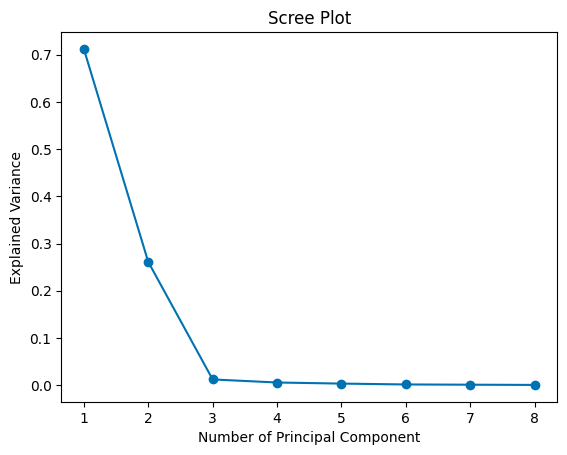

In [ ]:
explained_variance_ratio = pca.explained_variance_ratio_

x_range = [x for x in range(0, len(explained_variance_ratio))]
x_range_labels = [x+1 for x in range(0, len(explained_variance_ratio))]
plt.plot(x_range, explained_variance_ratio, marker='o')
plt.xticks(ticks=x_range,labels=x_range_labels)
plt.xlabel('Number of Principal Component')
plt.ylabel('Explained Variance')
plt.title('Scree Plot')
plt.show()

In [ ]:
# Creating masks from trial events - to assign different colours to time points

stim_1_mask = np.zeros((RNN_firing_rates.shape[1]))
stim_2_mask = np.zeros((RNN_firing_rates.shape[1]))
decision_time_mask = np.zeros((RNN_firing_rates.shape[1]))
delay_mask = np.ones((RNN_firing_rates.shape[1]))

stim_1_mask[tp['stim1_onset_time']//dt:(tp['stim1_onset_time'] + tp['stim1_duration'])//dt] = 1
stim_2_mask[(tp['stim1_onset_time'] + tp['stim1_duration'] + tp['delay_between_stimuli'])//dt:(tp['stim1_onset_time'] + tp['stim1_duration'] + tp['delay_between_stimuli'] + tp['stim2_duration'])//dt] = 1
decision_time_mask[(tp['stim1_onset_time'] + tp['stim1_duration'] + tp['delay_between_stimuli'] + tp['stim2_duration'] + tp['delay_before_decision_time'])//dt:(tp['stim1_onset_time'] + tp['stim1_duration'] + tp['delay_between_stimuli'] + tp['stim2_duration'] + tp['stim2_duration'] + tp['delay_before_decision_time'] + tp['decision_time_duration'])//dt] = 1

stim_1_mask = stim_1_mask.astype(bool)
stim_2_mask = stim_2_mask.astype(bool)
decision_time_mask = decision_time_mask.astype(bool)

delay_mask[stim_1_mask] = 0
delay_mask[stim_2_mask] = 0
delay_mask[decision_time_mask] = 0
delay_mask = delay_mask.astype(bool)

In [ ]:
match_trials = np.where(RNN_data['y_t'][:,-1,0] > RNN_data['y_t'][:,-1,1])
non_match_trials = np.where(RNN_data['y_t'][:,-1,0] < RNN_data['y_t'][:,-1,1])
print(match_trials)
print(non_match_trials)

(array([ 2,  3,  5,  6,  8, 10, 11, 13, 14, 16, 18, 19, 21, 22, 27, 28, 29,
       32, 44, 46, 47, 48, 49]),)
(array([ 0,  1,  4,  7,  9, 12, 15, 17, 20, 23, 24, 25, 26, 30, 31, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 45]),)


trajectories_collected1 shape (23, 240, 3)
trajectories_collected2 shape (27, 240, 3)


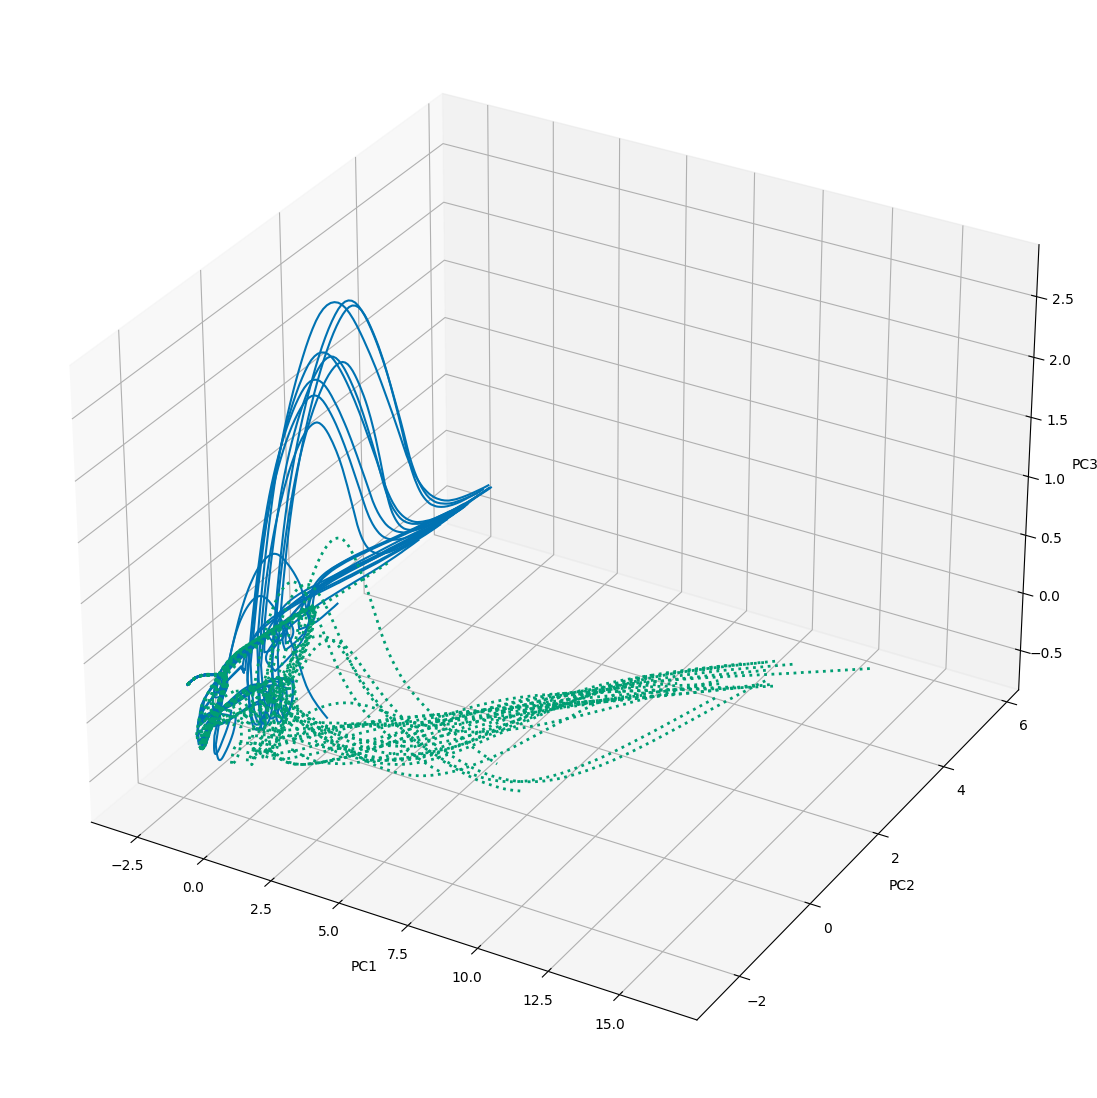

In [ ]:
# trials_to_plot = [i for i in range(50)]
# trials_to_plot = [45]
# trials_to_plot = [5,6,0,11]
trials_to_plot = match_trials[0]
# trials_to_plot = [6,10,13,14,16,18,21,22,28,32] # double reversal trials, all match trials

fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(111, projection="3d")

# Set the axis labels
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")


trajectories_collected1 = []
for i in trials_to_plot:
    pc_space_points = pca.transform(RNN_firing_rates[i,:,:])
    ax.plot(pc_space_points[:,0], pc_space_points[:,1], pc_space_points[:,2], color = 'C0')
    # ax.scatter(pc_space_points[:,0][delay_mask], pc_space_points[:,1][delay_mask], pc_space_points[:,2][delay_mask], s=5.5, c='blue')
    # ax.scatter(pc_space_points[:,0][stim_1_mask], pc_space_points[:,1][stim_1_mask], pc_space_points[:,2][stim_1_mask], s=5.5, c='r')
    # ax.scatter(pc_space_points[:,0][stim_2_mask], pc_space_points[:,1][stim_1_mask], pc_space_points[:,2][stim_2_mask], s=5.5, c='r')
    # ax.scatter(pc_space_points[:,0][decision_time_mask], pc_space_points[:,1][decision_time_mask], pc_space_points[:,2][decision_time_mask], s=5.5, c='g')
    trajectories_collected1.append(pc_space_points[:,:3])
trajectories_collected1 = np.array(trajectories_collected1)
print('trajectories_collected1 shape',trajectories_collected1.shape)

trajectories_collected2 = []
trials_to_plot = non_match_trials[0]
for i in trials_to_plot:
    pc_space_points = pca.transform(RNN_firing_rates[i,:,:])
    ax.plot(pc_space_points[:,0], pc_space_points[:,1], pc_space_points[:,2], color = 'C1', linestyle='dotted', linewidth=2)
    trajectories_collected2.append(pc_space_points[:,:3])
trajectories_collected2 = np.array(trajectories_collected2)
print('trajectories_collected2 shape',trajectories_collected2.shape)


plt.show()

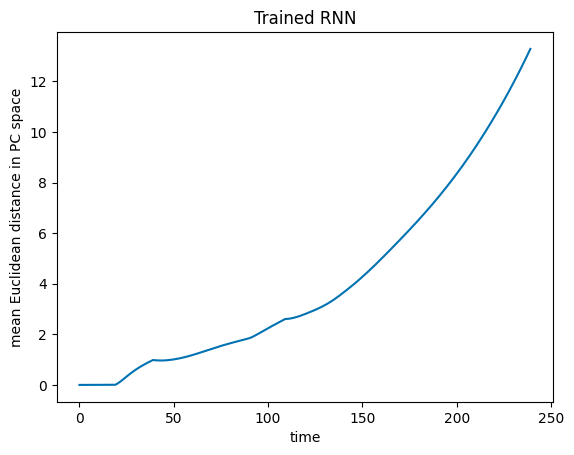

In [ ]:
distances = []
for i in range(trajectories_collected1.shape[0]):
    for j in range(trajectories_collected2.shape[0]):
        dist = np.sqrt(np.sum((trajectories_collected1[i,:,:] - trajectories_collected2[j,:,:])**2, axis=1))
        distances.append(dist)
mean_distance = np.array(distances).mean(axis=0)

plt.plot(mean_distance)
plt.xlabel('time')
plt.ylabel('mean Euclidean distance in PC space')
plt.title('Trained RNN')
plt.show()

In [ ]:
# X_embedded = TSNE(n_components=3).fit_transform(flattened_firing_rates) # https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
# print(X_embedded.shape)

NameError: ignored

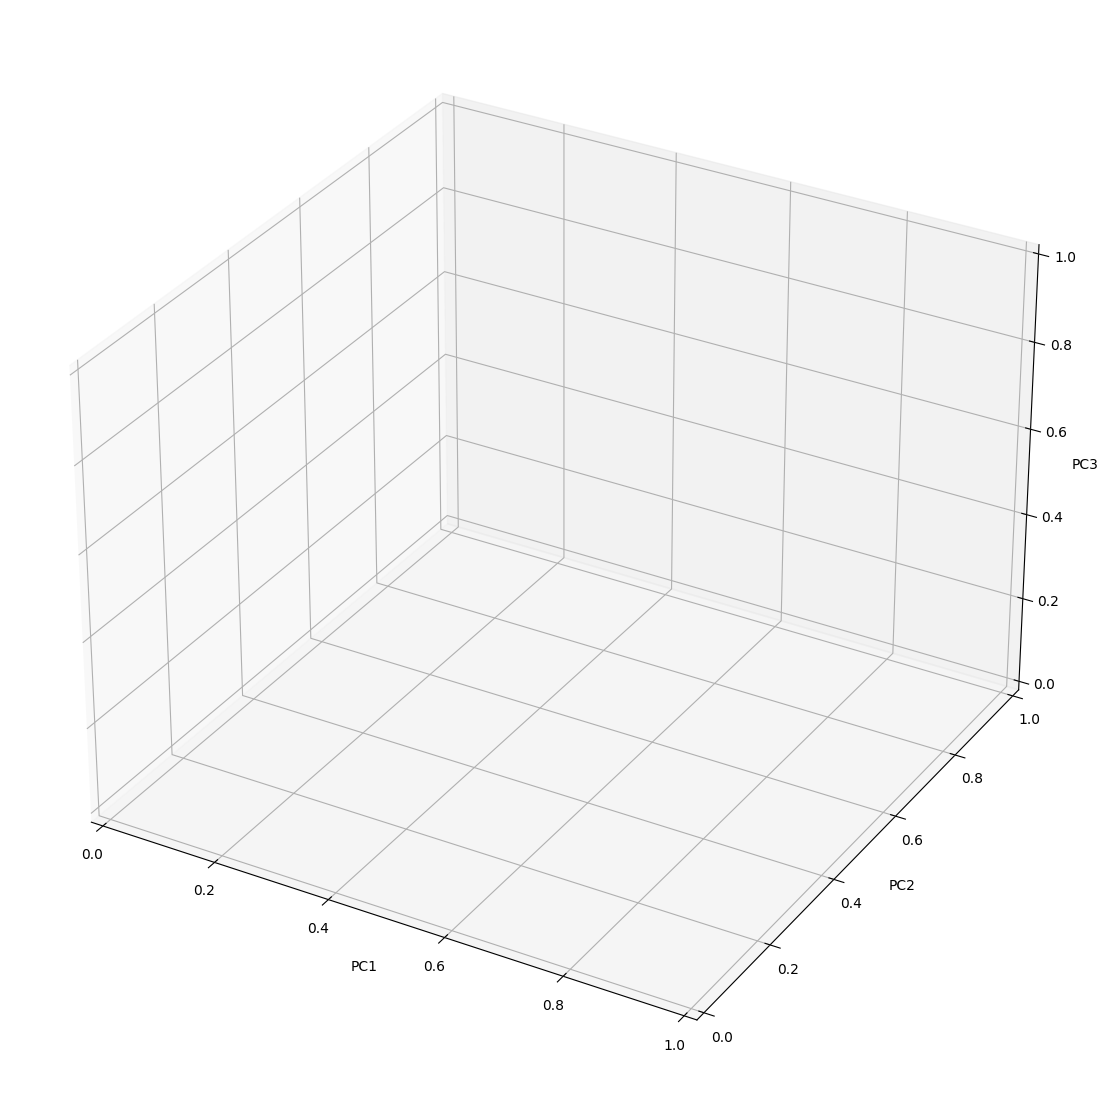

In [ ]:
# fig = plt.figure(figsize=(14,14))
# ax = fig.add_subplot(111, projection="3d")

# # Set the axis labels
# ax.set_xlabel("PC1")
# ax.set_ylabel("PC2")
# ax.set_zlabel("PC3")

# ax.scatter(X_embedded[:,0], X_embedded[:,1], X_embedded[:,2], s=5.5, c='blue')